# Set Up

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import random
import math
%matplotlib inline

from os import path, getcwd
from glob import glob

code_dir = getcwd()
data_dir = path.expanduser('~/data/workshop-content18/3-snc/data/')

ais_pathnames = glob(data_dir + '*.txt')
ais_basenames = [path.basename(pn) for pn in ais_pathnames]

delta_cur_basename = next(bn for bn in ais_basenames if 'Deltaport_Current' in bn)
delta_his_basename = next(bn for bn in ais_basenames if 'Deltaport_History' in bn)
nwest_cur_basename = next(bn for bn in ais_basenames if 'NewWestminster_Current' in bn)
nwest_his_basename = next(bn for bn in ais_basenames if 'NewWestminster_History' in bn)

max_rows=int(3e6)
delta_cur = pd.read_csv(
    data_dir + delta_cur_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

delta_his = pd.read_csv(
    data_dir + delta_his_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

nwest_cur = pd.read_csv(
    data_dir + nwest_cur_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

nwest_his = pd.read_csv(
    data_dir + nwest_his_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

delta_cur = pd.concat([delta_cur, delta_his, nwest_cur, nwest_his])

In [2]:
# Only keep interesting data and drom the data missing stuff
#delta_cur = delta_cur.loc[:, ['UserID', 'Longitude', 'Latitude', 'ROT']]
print(delta_cur.size)
delta_cur = delta_cur.dropna()
print(delta_cur.size)

127290540
127290504


# Ship Distribution

Here we can compute 2d histogram of ship distribution

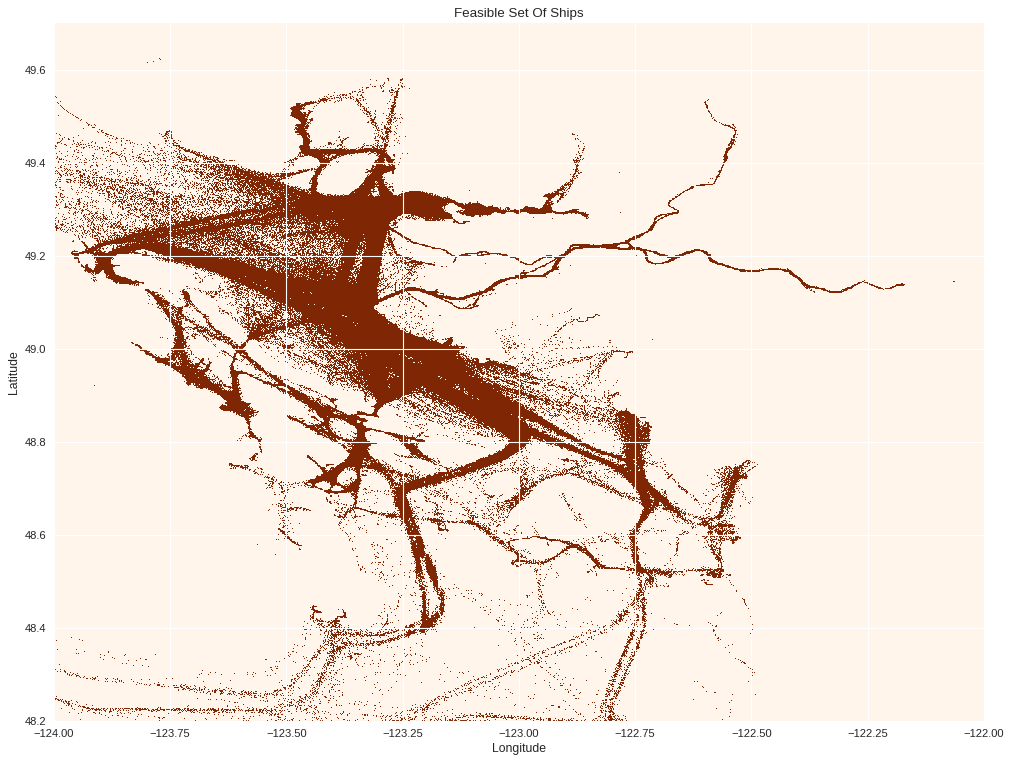

In [6]:
NUM = 1000

x = delta_cur.Longitude[~np.isnan(delta_cur.Longitude)]
y = delta_cur.Latitude[~np.isnan(delta_cur.Latitude)]

START_X = -124
END_X = -122

START_Y = 48.2
END_Y = 49.7

xedges = np.linspace(START_X, END_X, num=NUM)
yedges = np.linspace(START_Y, END_Y,num=NUM)

dx = (END_X - START_X)/NUM
dy = (END_Y - START_Y)/NUM

H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))

H = H.T  # Let each row list bins with common y range.

H[H>0] = 1
fig = plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Longitude", ylabel="Latitude", title="Feasible Set Of Ships")
plt.imshow(H, interpolation='nearest', origin='low',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=mpl.cm.Oranges)

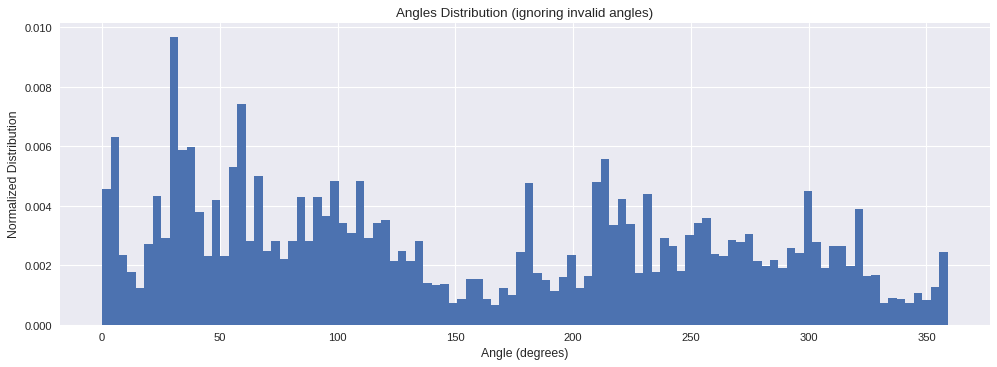

In [4]:
# Select ships within a certain bin, and compute mean heading (ignore)
good_angles = delta_cur.loc[delta_cur['TrueHeading'] < 360]
fig = plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Angle (degrees)", ylabel="Normalized Distribution",
                     title="Angles Distribution (ignoring invalid angles)")
h = plt.hist(good_angles.loc[:, ['TrueHeading']].values, normed=True, bins=100)

In [5]:
angls_at_a_point = good_angles.loc[(good_angles['Longitude'] > START_X + i * dx) &
                                   (good_angles['Longitude'] < START_X + (i+1) * dx) &
                                   (good_angles['Latitude'] > START_Y + j * dy) &
                                   (good_angles['Latitude'] < START_Y + (j+1) * dy)]

fig = plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Angle (degrees)", ylabel="Normalized Distribution",
                     title="Angles Distribution at a point")
h = plt.hist(angls_at_a_point.loc[:, ['TrueHeading']].values, normed=True, bins=100)

NameError: name 'i' is not defined

In [ ]:
print('mean: ', np.mean(angls_at_a_point.TrueHeading.values))
print('std: ', np.std(angls_at_a_point.TrueHeading.values))

# Motion map
Now let's build a scalar field of ship directions of motion

In [ ]:
# dmap: direction map
dmap = np.zeros([NUM,NUM])
for i in range(0,NUM):
    for j in range(0,NUM):
        dmap[j,i] = np.mean(good_angles.loc[(good_angles['Longitude'] > START_X + i * dx) &
                                            (good_angles['Longitude'] < START_X + (i+1) * dx) &
                                            (good_angles['Latitude'] > START_Y + j * dy) &
                                            (good_angles['Latitude'] < START_Y + (j+1) * dy)].TrueHeading.values)

In [ ]:
fig = plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Longitude", ylabel="Latitude", title="Direction of ships")


cax = plt.imshow(dmap, interpolation='nearest', origin='low',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=mpl.cm.Oranges)

cbar = fig.colorbar(cax)

# Unit Motion Vector Field
Now we can turn this into a unit motion vector field...

In [ ]:
U = np.cos(dmap) # x dir
V = np.sin(dmap) # y dir

plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Longitude", ylabel="Latitude", title="Direction of ships")
Q = plt.quiver(U, V)
qk = plt.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')